## Project setup

We define the project root directory and add it to the Python path.  
This ensures that modules inside the `src` folder can be imported cleanly from anywhere inside the notebook.

This is needed because Python, by default, only searches the working directory for imports, not parent folders.

No financial logic is performed here.  
It is simply an environment setup step.


In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROJECT_ROOT


WindowsPath('C:/Users/crowe/OneDrive - University College Dublin/Masters/FIN42020 - Derivative Securities/Project/FIN42020-Derivative-Securities-Project')

## Loading option chains and constructing mid prices

We load four datasets:

- the call option chain  
- the put option chain  
- the underlying CAT stock price history  
- the 1 month US Treasury bill yield (risk free rate proxy)

The loader functions clean column names, parse dates, and return tidy DataFrames.

Next, we compute mid quotes for calls and puts:

$$
\text{Mid} = \frac{\text{Bid} + \text{Ask}}{2}
$$

Mid prices are preferred over last trade prices, because:

- last trades may be stale  
- mid prices incorporate current liquidity conditions  
- put call parity and IV inversion assume frictionless pricing, so mid quotes are the closest approximation

This step prepares the option data for parity checks and implied volatility estimation.


In [2]:
import numpy as np
import pandas as pd

from src.data_loader import (
    load_calls, load_puts, load_price, load_usgg1m,
    TRADE_DATE, EXPIRY_DATE,
)

calls = load_calls().copy()
puts = load_puts().copy()
price = load_price()
usgg = load_usgg1m()

# mid prices
calls["Mid"] = 0.5 * (calls["Bid"] + calls["Ask"])
puts["Mid"] = 0.5 * (puts["Bid"] + puts["Ask"])

calls.head(), puts.head()


(   Strike             Ticker         Bid         Ask        Last        IVM  \
 0     340  CAT 10/17/25 C340  126.800003  128.699997    0.000000  54.544857   
 1     350  CAT 10/17/25 C350  116.849991  118.800003  117.220001  50.927101   
 2     360  CAT 10/17/25 C360  106.100006  108.599991  108.050003   0.000000   
 3     370  CAT 10/17/25 C370   97.099991   98.899994    0.000000  43.885979   
 4     380  CAT 10/17/25 C380   86.899994   89.050003    0.000000  38.892742   
 
    Volm         Mid  
 0     0  127.750000  
 1     2  117.824997  
 2     1  107.349998  
 3     0   97.999992  
 4     0   87.974998  ,
    Strike             Ticker   Bid   Ask  Last        IVM  Volm    Mid
 0     340  CAT 10/17/25 P340  0.05  0.26  0.15  47.592529     1  0.155
 1     350  CAT 10/17/25 P350  0.00  0.52  0.24  51.844082     2  0.260
 2     360  CAT 10/17/25 P360  0.10  0.55  0.00  44.148312     0  0.325
 3     370  CAT 10/17/25 P370  0.22  0.39  0.23  39.720551    12  0.305
 4     380  CAT 10/

## Extracting $(S_0)$, $(r)$, and $(T)$

Three key quantities are required for Black Scholes pricing and put call parity:

1. **Spot price $(S_0)$**  
   The underlying CAT stock price on the trade date.  
   Extracted directly from the `Price` sheet.

2. **Risk free rate $(r)$**  
   We take the first available 1-month Treasury Bill yield on or after the trade date.  
   This rate matches the maturity horizon of the option reasonably well.

3. **Time to maturity $(T)$**  
   Computed in years as:

   $$
   T = \frac{\text{Expiry Date} - \text{Trade Date}}{365}
   $$

These values are used in:
- put call parity  
- Black Scholes pricing  
- implied volatility inversion  
- later, delta hedging simulations.


In [3]:
# stock price on trade date
S0 = price.loc[price["Date"] == TRADE_DATE, "PX_LAST"].iloc[0]

# risk free rate on trade date, take first value on or after trade date
r_row = usgg.loc[usgg["Date"] >= TRADE_DATE].iloc[0]
r = float(r_row["Rate"])  # assume already in decimal, eg 0.045

# time to expiry in years
T_days = (EXPIRY_DATE - TRADE_DATE).days
T = T_days / 365.0

S0, r, T


(np.float64(466.54), 0.040304, 0.07671232876712329)

## Put–call parity construction

We merge the call and put chains on strike so that for each strike $(K)$ we have:

- $(C_{\text{mid}})$: mid call price  
- $(P_{\text{mid}})$: mid put price  

We compute:

$$
\text{lhs} = C_{\text{mid}} - P_{\text{mid}}
$$

and the theoretical right-hand side under **no dividends** and **European exercise**:

$$
\text{rhs} = S_0 - K e^{-rT}
$$

The parity gap is:

$$
\text{gap} = \text{lhs} - \text{rhs}
$$

Interpretation:

- If $(\text{gap} = 0)$, parity holds exactly  
- If $(\text{gap} \neq 0)$, deviations can arise from  
  - bid ask spreads  
  - early exercise premia (American puts)  
  - dividends, which we are intentionally ignoring  
  - stale quotes or microstructure noise

This comparison checks internal consistency of the option chain.


In [4]:
# merge calls and puts on Strike
cp = pd.merge(
    calls[["Strike", "Mid"]],
    puts[["Strike", "Mid"]],
    on="Strike",
    suffixes=("_call", "_put"),
)

cp["rhs"] = S0 - cp["Strike"] * np.exp(-r * T)
cp["lhs"] = cp["Mid_call"] - cp["Mid_put"]
cp["parity_gap"] = cp["lhs"] - cp["rhs"]

cp


,Strike,Mid_call,Mid_put,rhs,lhs,parity_gap
0,340,127.750000,0.155000,127.589593,127.595000,0.005407
1,350,117.824997,0.260000,117.620464,117.564997,-0.055467
2,360,107.349998,0.325000,107.651334,107.024998,-0.626336
3,370,97.999992,0.305000,97.682204,97.694992,0.012788
4,380,87.974998,0.370000,87.713075,87.604998,-0.108076
5,390,78.250000,0.500000,77.743945,77.750000,0.006055
6,400,68.449997,0.745000,67.774816,67.704997,-0.069819
7,410,58.349998,1.090000,57.805686,57.259999,-0.545687
8,420,49.424995,1.575000,47.836556,47.849996,0.013439
9,430,40.399994,2.705000,37.867427,37.694994,-0.172433


## Visualising parity deviations

We plot the parity gap as a function of strike.

This helps identify whether deviations:

- are random noise, or  
- show systematic patterns across strikes

For example:

- a downward sloping pattern usually indicates omitted dividends  
- large gaps at deep OTM strikes typically reflect wide bid ask spreads  
- near zero gaps near the money indicate internally consistent quotes

This plot provides a diagnostic check before running more advanced models.


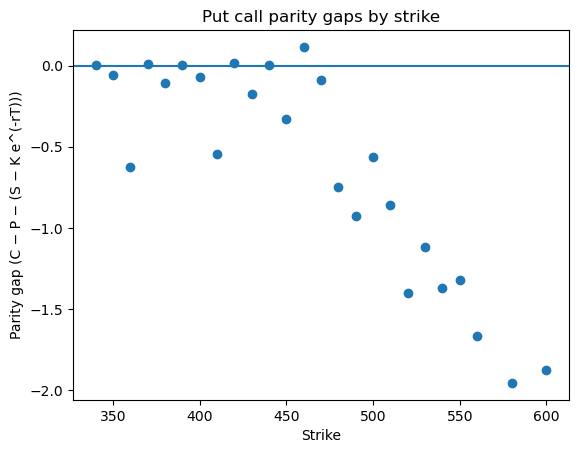

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(cp["Strike"], cp["parity_gap"])
plt.axhline(0)
plt.xlabel("Strike")
plt.ylabel("Parity gap (C − P − (S − K e^(-rT)))")
plt.title("Put call parity gaps by strike")
plt.show()


## Black Scholes model and implied volatility inversion

### Why we need this

The Black Scholes formula prices a European call option as:

$$
C_{\text{BS}}(S_0, K, T, r, \sigma)
$$

where $(\sigma)$ is volatility.

Bloomberg reports **implied volatilities (`IVM`)**, which are the values of $(\sigma)$ such that:

$$
C_{\text{BS}}(\sigma) = C_{\text{market}}
$$

We invert the pricing equation numerically using a root finder (Brent's method):

$$
\text{Find } \sigma \text{ such that } C_{\text{BS}}(\sigma) - C_{\text{mid}} = 0
$$
### Notes

- Deep ITM options whose mids equal intrinsic value produce no valid IV  
- American options introduce bias versus European BS  
- Ignoring dividends causes Bloomberg IV and our IV to differ slightly

This IV series will later be used to compute:
- the volatility smile  
- model diagnostics  
- and as part of risk neutral hedging analysis.


In [6]:
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq

def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)


def implied_vol_call(price, S, K, T, r, sigma_low=1e-4, sigma_high=5.0):
    """Solve for sigma such that BS call price matches given price."""
    if price <= max(S - K * exp(-r * T), 0):  # below intrinsic
        return np.nan

    def f(sigma):
        return bs_call_price(S, K, T, r, sigma) - price

    try:
        return brentq(f, sigma_low, sigma_high, maxiter=100)
    except ValueError:
        return np.nan


In [7]:
cp_iv = calls.copy()
cp_iv["IV_calc"] = [
    implied_vol_call(row["Mid"], S0, row["Strike"], T, r)
    for _, row in cp_iv.iterrows()
]

cp_iv[["Strike", "IVM", "IV_calc"]]


,Strike,IVM,IV_calc
0,340,54.544857,0.487144
1,350,50.927101,0.461617
2,360,0.000000,NaN
3,370,43.885979,0.407412
4,380,38.892742,0.356587
5,390,37.259842,0.353236
6,400,34.281212,0.328595
7,410,28.890646,0.273933
8,420,30.160873,0.296346
9,430,28.661461,0.284147


## Comparing market implied volatility (`IVM`) with Black Scholes implied volatility (`IV_calc`)

We compare:

- `IVM`: Bloomberg’s quoted implied volatility  
- `IV_calc`: our Black Scholes implied volatility estimates using mid prices

Interpretation:

- Differences are expected because the Black Scholes model we use:
  - ignores dividends  
  - assumes European exercise  
  - uses mid quotes rather than full order book  
- The *shape* (smile or skew) should still match closely  
- Large deviations at deep ITM or deep OTM strikes usually reflect:
  - poor liquidity  
  - early exercise premia  
  - stale quotes  

If the calculated and Bloomberg implied vols align reasonably well,  
we can trust our pricing and hedging framework.


In [17]:
iv = cp_iv.copy()
iv = iv.replace({"IVM": {0.0: np.nan}})
iv = iv.dropna(subset=["IVM", "IV_calc"]).reset_index(drop=True)

# convert Bloomberg IV from percent to decimal
iv["IVM_dec"] = iv["IVM"] / 100.0


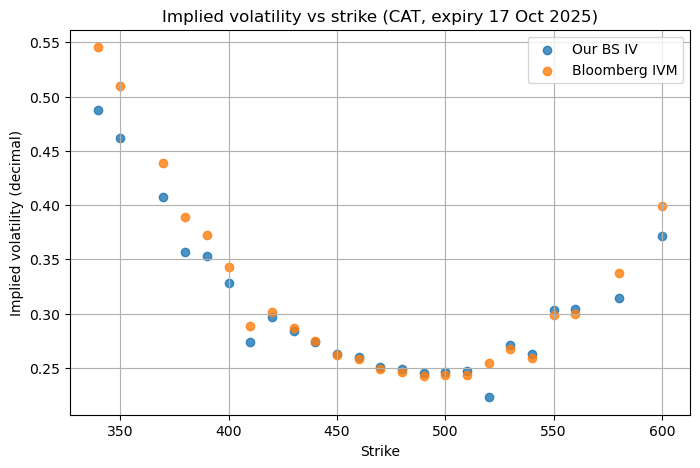

In [18]:
plt.figure(figsize=(8, 5))
plt.scatter(iv["Strike"], iv["IV_calc"], label="Our BS IV", alpha=0.8)
plt.scatter(iv["Strike"], iv["IVM_dec"], label="Bloomberg IVM", alpha=0.8)

plt.xlabel("Strike")
plt.ylabel("Implied volatility (decimal)")
plt.title("Implied volatility vs strike (CAT, expiry 17 Oct 2025)")
plt.legend()
plt.grid(True)
plt.show()
